In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from dmba import regressionSummary, exhaustive_search

%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
# Load dataset
IBM_DF = pd.read_csv('HR-Employee-Attrition.csv')

# Dropping unnecessary columns 
IBM_DF.drop(columns=['EmployeeNumber', 'Over18', 'EmployeeCount', 'StandardHours'], inplace=True)

In [3]:

# Drop duplicates
IBM_DF.drop_duplicates(inplace=True)  
 
# Encoding categorical variables
le = LabelEncoder()
categorical_columns = IBM_DF.select_dtypes(include=['object']).columns
for col in categorical_columns:
    IBM_DF[col] = le.fit_transform(IBM_DF[col])


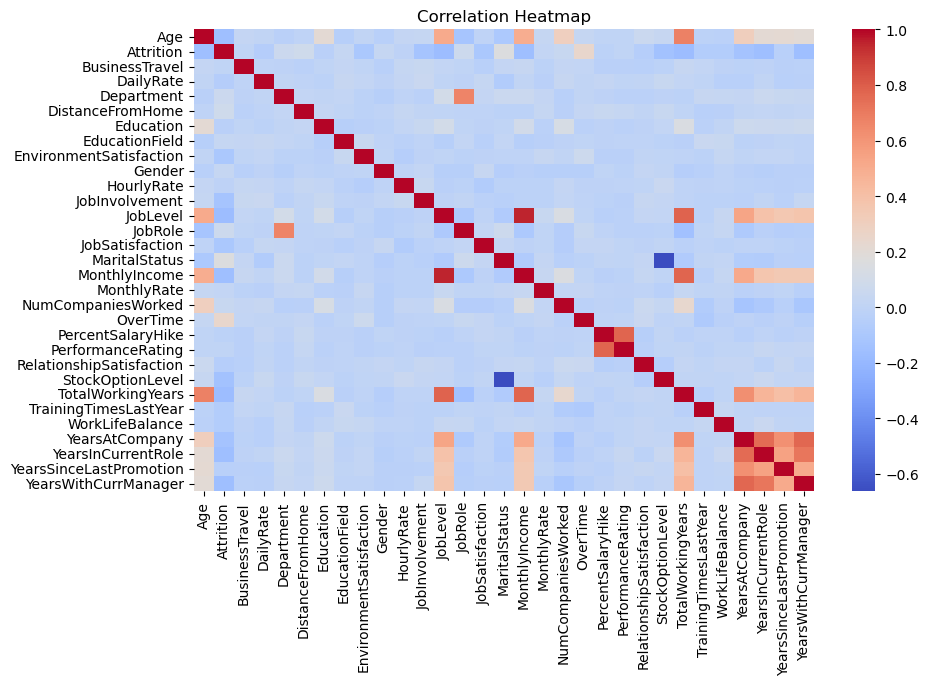

In [4]:
# Exploratory Data Analysis
plt.figure(figsize=(10, 6))
sns.heatmap(IBM_DF.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [5]:
## XGBoost Model with Class Weights (high Recall Focus)
# Split data
X = IBM_DF.drop(columns=['Attrition'])
y = IBM_DF['Attrition'].astype(int)
# Convert target labels to binary (0 and 1)
y = y.replace(2,1)
#training split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1, shuffle=True)
# Feature Scaling
scaler = StandardScaler()
numeric_columns = train_X.select_dtypes(include=['int64', 'float64']).columns
# Fit on train and transform valid
train_X[numeric_columns] = scaler.fit_transform(train_X[numeric_columns])
valid_X[numeric_columns] = scaler.transform(valid_X[numeric_columns])
#Calculate class weights
count_neg = (train_y == 0).sum()
count_pos = (train_y == 1).sum()
scale_pos_weight = count_neg / count_pos
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")
#XGBoost model with the calculated weights
xgb_clf_weighted = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
#fit model
xgb_clf_weighted.fit(train_X, train_y)
#prediction on validation set
xgb_pred_default = xgb_clf_weighted.predict(valid_X)
xgb_proba = xgb_clf_weighted.predict_proba(valid_X)[:, 1] #Attrition Probability
print('XGBoost with Class Weights (Default Threshold of 0.5):\n')
print("XGB Classification_report:\n", classification_report(valid_y, xgb_pred_default))
# Calculate for all possible cutoffs
precision, recall, thresholds = precision_recall_curve(valid_y, xgb_proba)
# Find the optimal threshold for a Recall oof at least 70%
target_recall = 0.60
threshold_for_target_recall = 0
# Iterate through thresholds to find the one that gives the desired recall
for p, r, t in zip(precision[::-1], recall[::-1], thresholds[::-1]):
    if r >= target_recall:
        threshold_for_target_recall = t
        optimal_precision = p
        break
#Generate new predictions using the optimal threshold
new_xgb_pred = (xgb_proba >= threshold_for_target_recall).astype(int)

Calculated scale_pos_weight: 5.53
XGBoost with Class Weights (Default Threshold of 0.5):

XGB Classification_report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       486
           1       0.58      0.34      0.43       102

    accuracy                           0.84       588
   macro avg       0.73      0.65      0.67       588
weighted avg       0.82      0.84      0.83       588



In [6]:
#fit logistic regression
logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)
#prediction
logit_reg_pred = logit_reg.predict(valid_X)                  


In [7]:
#Initialize SHAP explainer with new weighted XGBoost model
explainer = shap.TreeExplainer(xgb_clf_weighted)
#Calculate Shap values for the validation set
shap_values = explainer.shap_values(valid_X)

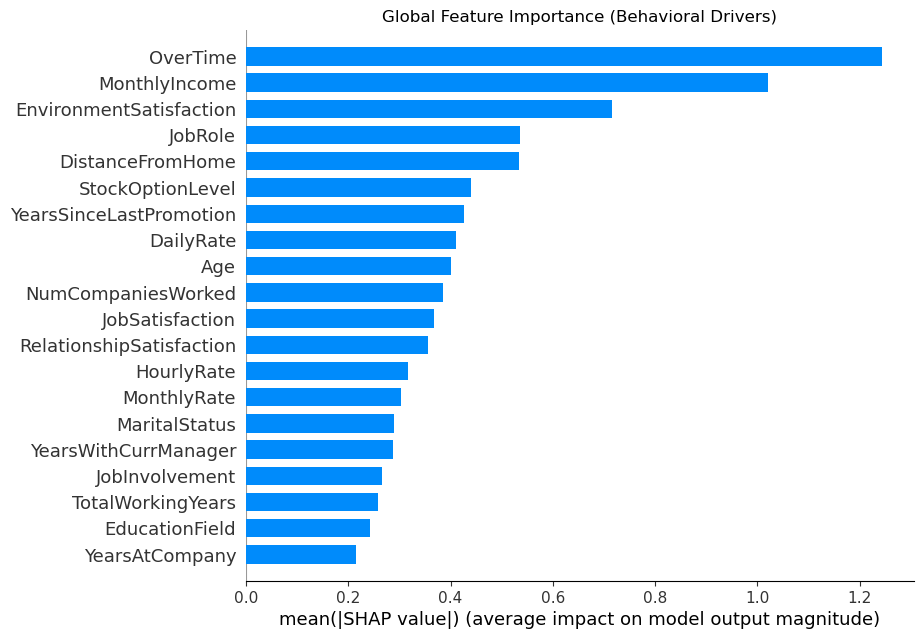

In [8]:
#Visualize Global Feature Importance (Behavioral Drivers)
#Plot shows top features driving attrition across entire company
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, valid_X, plot_type="bar", show=False)
plt.title('Global Feature Importance (Behavioral Drivers)')
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.show()


SHAP Waterfall Plot for Employee Index: 1153 (Predicted Leaver)



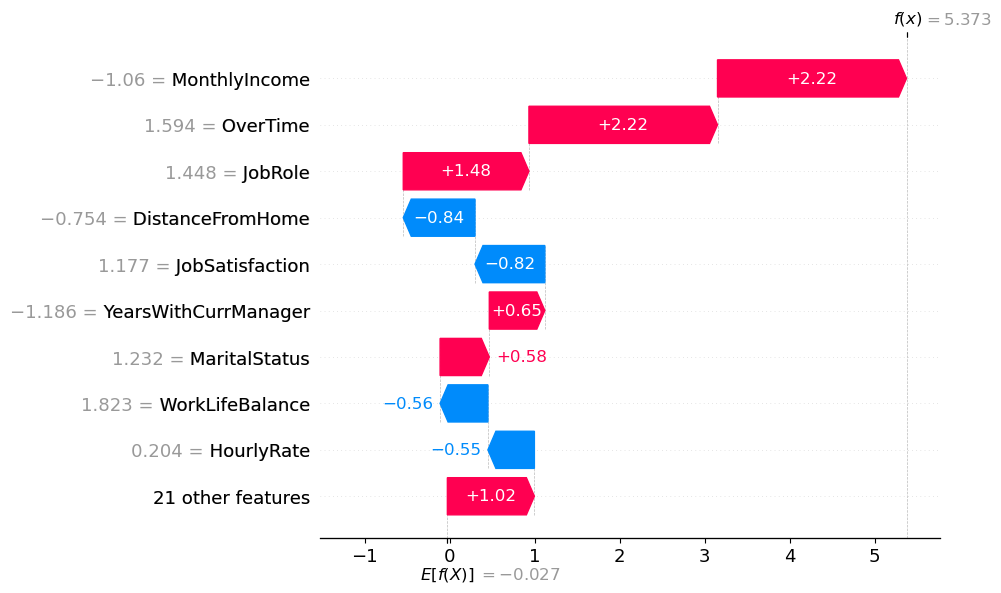

In [9]:
# Create local interpretation plot for a specific employee (Waterfall)
leaver_indices = valid_X[(valid_y == 1) & (new_xgb_pred == 1)].index
if len(leaver_indices) > 0:
   idx_to_explain = leaver_indices[0]
   employee_shap_values = explainer(valid_X)[valid_X.index.get_loc(idx_to_explain)]

   print(f"\nSHAP Waterfall Plot for Employee Index: {idx_to_explain} (Predicted Leaver)\n")
   plt.figure(figsize=(10, 6))
   shap.plots.waterfall(employee_shap_values, show=True)
else:
   print("Could not find a True Positive (TP) example to plot.")

In [10]:
# Model Evaluation
# Metrics

print("XGBoost with Class Weights")
print("XGBoost (Threshold Optimized) Classification_report:\n", classification_report(valid_y, new_xgb_pred))
print("XGBoost Confusion Matrix:\n", confusion_matrix(valid_y, new_xgb_pred))
print("Logistic Regression Classification Report:\n", classification_report(valid_y, logit_reg_pred))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(valid_y, logit_reg_pred))


XGBoost with Class Weights
XGBoost (Threshold Optimized) Classification_report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86       486
           1       0.42      0.61      0.49       102

    accuracy                           0.78       588
   macro avg       0.66      0.71      0.68       588
weighted avg       0.82      0.78      0.80       588

XGBoost Confusion Matrix:
 [[399  87]
 [ 40  62]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       486
           1       0.68      0.31      0.43       102

    accuracy                           0.86       588
   macro avg       0.78      0.64      0.67       588
weighted avg       0.84      0.86      0.83       588

Logistic Regression Confusion Matrix:
 [[471  15]
 [ 70  32]]
